In [72]:
%matplotlib inline
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageOps

# Prepare data

Take a look at the dimension of the boxes first:

In [14]:
# Load data
input_dir = Path("../kuzushiji_data")
train_dir = input_dir/'train_images'

train_df = pd.read_csv(input_dir/'train.csv')
# Inspect train.csv
train_df.tail(n=10)

,image_id,labels
3871,umgy012-034,U+309D 875 807 25 32 U+309D 1441 2309 21 34 U+...
3872,umgy012-035,U+30D8 186 2397 61 32 U+3078 1288 481 85 35 U+...
3873,umgy012-036,U+3070 55 2449 81 40 U+30DE 1391 1941 56 47 U+...
3874,umgy012-037,U+304B 499 2183 32 40 U+306F 754 2593 85 40 U+...
3875,umgy012-038,U+30FD 876 792 23 25 U+3078 256 2342 94 39 U+5...
3876,umgy012-039,U+309D 426 456 30 34 U+306F 584 359 82 45 U+30...
3877,umgy012-040,U+30DE 677 327 68 35 U+3078 1424 463 110 43 U+...
3878,umgy012-041,U+309D 1582 802 16 34 U+306F 597 2337 72 42 U+...
3879,umgy012-042,U+4E00 1050 898 86 21 U+309D 724 1864 27 29 U+...
3880,umgy012-043,NaN


In [5]:
# Extract all width, height aspect ratios of the characters
image_ids, width, height, ar = [], [], [], []
train_df = train_df[train_df['labels'].notnull()]  # remove null labels

for idx in range(train_df.shape[0]):
    image_id = train_df.iloc[idx]['image_id']
    rowLabel = train_df.iloc[idx]['labels']
    allLabels = np.array(rowLabel.split(" ")).reshape(-1, 5)
    for label in allLabels:
        character, x, y, w, h = label
        x, y, w, h = int(x), int(y), int(w), int(h)
        image_ids.append(image_id)
        width.append(w)
        height.append(h)
        ar.append(h/w)

In [6]:
# Put them in a data frame
character_ar = pd.DataFrame({'image_id': image_id, 'width': width, 'height': height, 'aspect ratio': ar})
character_ar.head()

,aspect ratio,height,image_id,width
0,0.398496,53,umgy012-042,133
1,0.821429,69,umgy012-042,84
2,0.482517,69,umgy012-042,143
3,1.716981,91,umgy012-042,53
4,1.508197,92,umgy012-042,61


In [7]:
def plot_hist_from_list(data, xlabel, ylabel, bins=50):    
    plt.hist(data, density=True, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

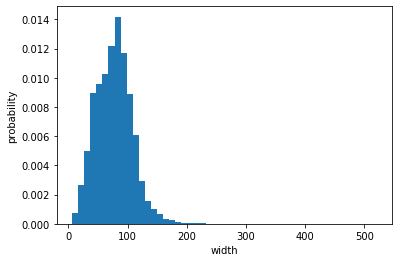

In [8]:
plot_hist_from_list(width, 'width', 'probability')

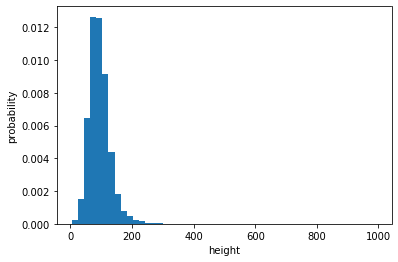

In [9]:
plot_hist_from_list(height, 'height', 'probability')

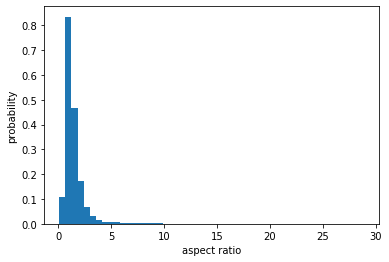

In [10]:
plot_hist_from_list(ar, 'aspect ratio', 'probability')

In [27]:
# Find the image that has characters with huge aspect ratios
outliers = character_ar[character_ar['aspect ratio'] > 20]
outliers.head(n=10)

,aspect ratio,height,image_id,width
63139,20.800000,208,umgy012-042,10
72718,22.727273,250,umgy012-042,11
75689,25.000000,175,umgy012-042,7
77226,26.400000,264,umgy012-042,10
81546,28.666667,258,umgy012-042,9
82290,20.800000,208,umgy012-042,10
96547,20.454545,225,umgy012-042,11
102026,21.888889,197,umgy012-042,9
106179,20.909091,230,umgy012-042,11
121286,20.250000,405,umgy012-042,20


In [12]:
def to_path(string):
    if ".jpg" not in string:
        string = string + ".jpg"
    return string

def display_image(image):
    plt.figure(figsize=(15,15))
    this_img = Image.open(train_dir/to_path(image))
    plt.imshow(this_img)
    return plt

<module 'matplotlib.pyplot' from '/Users/fanliu/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/pyplot.py'>

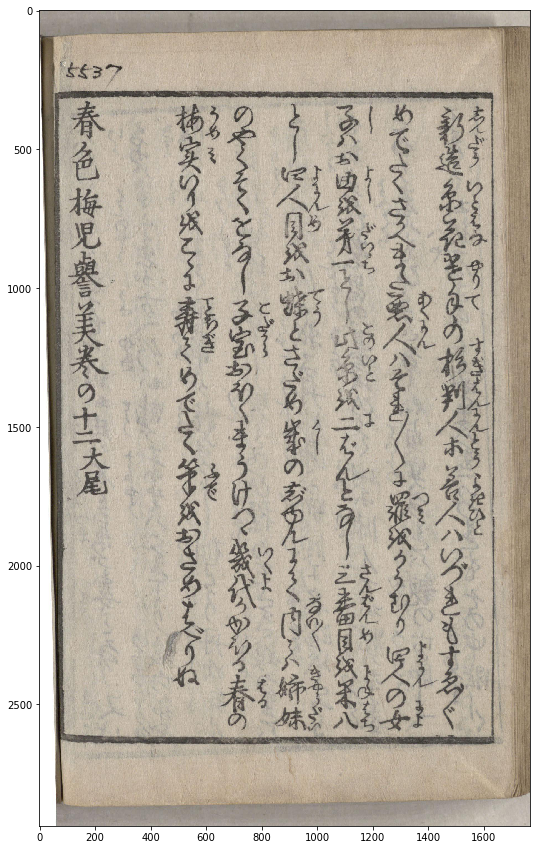

In [13]:
display_image('umgy012-042')

Extract out the characters from each image and put them together as training data, apply padding so that training images have the same size:

In [41]:
# use a small dataset first
subdata = train_df.iloc[-10:,]
subdata = subdata[subdata['labels'].notnull()]
subdata = subdata.reset_index(drop=True)

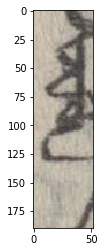

In [43]:
# for idx in range(subdata.shape[0]):
#     image_id = subdata.iloc[idx]['image_id']
#     labels = subdata.iloc[idx]['labels']
#     img = Image.open(train_dir/to_path(image_id))
    
#     allLabels = np.array(labels.split(" ")).reshape(-1, 5)
#     for label in allLabels:
#         character, x, y, w, h = label
#         x, y, w, h = int(x), int(y), int(w), int(h)
#         area = (x, y, x + w, y + h)
#         character = img.crop(area)
#         plt.imshow(character)

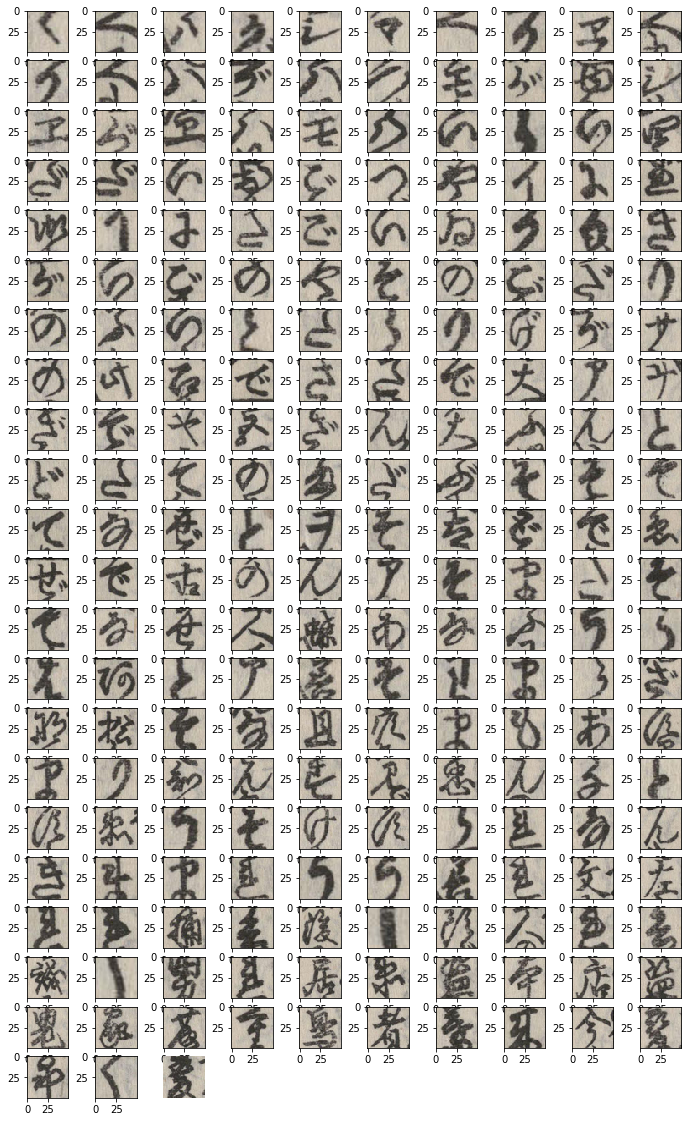

In [82]:
image_id = subdata.iloc[4]['image_id']
labels = subdata.iloc[4]['labels']
img = Image.open(train_dir/to_path(image_id))

allLabels = np.array(labels.split(" ")).reshape(-1, 5)
ncolumn = 10
nrow = len(allLabels) // ncolumn + 1
fig = plt.figure(figsize=(12, 20))

for idx in range(len(allLabels)):
    character, x, y, w, h = allLabels[idx]
    x, y, w, h = int(x), int(y), int(w), int(h)
    area = (x - 5, y - 5, x + w + 5, y + h + 5)
    character = img.crop(area)
    size = (50, 50)
    fit_and_resized_image = ImageOps.fit(character, size, Image.ANTIALIAS)
    plt.subplot(nrow, ncolumn, idx + 1)
    plt.imshow(fit_and_resized_image)
    
plt.axis('off')
plt.show()

# Build model

# Train model